In [31]:
import pandas as pd
import simplejson
import urllib
import matplotlib.pyplot as plt
import math
import random
from copy import copy
import geopy.distance
import geopandas as gpd
import geocoder
from itertools import combinations
import numpy as np

/Users/jakob.schuster/.pyenv/versions/3.7.13/envs/atcoenv/lib/python3.7/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


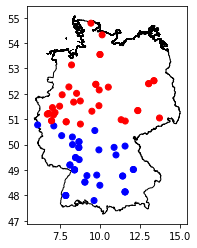

,Team,Stadt,Unnamed: 2,open_gamedays,Breitengrad,Längengrad,Region
0,1. RCK Kometen,Köln,NaN,5,50.938361,6.959974,200.0
1,1. Roundnet Club Dresden,Dresden,NaN,5,51.049329,13.738144,200.0
2,1. Roundnet Club Würzburg,Würzburg,NaN,5,49.792450,9.932966,150.0
3,1. Roundnet-Verein Mainz,Mainz,NaN,5,50.001231,8.276251,150.0
4,2Cans,Leipzig,NaN,5,51.340632,12.374733,200.0
...,...,...,...,...,...,...,...
70,Tübinger Eisvögel III,Tübingen,NaN,5,48.523616,9.053553,150.0
71,Weingarten Wizards,Weingarten (Ravensburg),NaN,5,47.796887,9.627625,150.0
72,West Wings Essen,Essen,NaN,5,51.458224,7.015817,200.0
73,Wuppertaler Roundnet Community,Wuppertal,NaN,5,51.264018,7.178037,200.0


In [113]:
def preparing_xlsx(filename: str, season_length: int, x_north=200, x_south=150): -> pd.DataFrame
    def get_coordinates(city_name):
        g = geocoder.osm(city_name)
        return pd.Series([g.osm["y"], g.osm["x"]])

    #df_org = pd.read_csv(filename, usecols=["Team","Stadt"])
    df = pd.read_excel(filename,)
    df["open_gamedays"] = season_length
    df[["Breitengrad","Längengrad"]] = df["Stadt"].apply(get_coordinates)
    
    threshold = df['Breitengrad'].median()
    df.loc[df['Breitengrad'] > threshold, 'Region'] = x_north
    df.loc[df['Breitengrad'] <= threshold, 'Region'] = x_south
    
    gdf = gpd.read_file("DEU_adm.zip")
    gdf.plot(color='white', edgecolor='black' )
    
    col = ["red" if x["Region"] == x_north else "blue" for idx, x in df.iterrows()]
    plt.scatter(df["Längengrad"],df["Breitengrad"], color=col)
    plt.show()
    
    return df


df = preparing_xlsx("deutsche-roundnet-liga-2023-2024-regionalliga.xlsx", 5)
df

In [119]:
def calc_penalty_matrix(df: pd.DataFrame, regio=False):
    adj_matrix = {}
    for index, row in df.iterrows():
        entry = {}
        for index2, row2, in df.iterrows():
            if index == index2:
                entry[row2["Team"]] = 100000
            elif row["Stadt"] == row2["Stadt"] and not regio:
                entry[row2["Team"]] = 100000
            else:
                y1,y2 = row["Breitengrad"],row2["Breitengrad"]
                x1, x2 = row["Längengrad"], row2["Längengrad"]
                factor = (row["Region"]+row2["Region"])/2
                entry[row2["Team"]] = max(0, factor-geopy.distance.geodesic((x1,y1),(x2,y2)).km)
        adj_matrix[row["Team"]] = entry
    return pd.DataFrame(adj_matrix, index=pd.Series(adj_matrix.keys()))

# regio decided if games in same community are allowed
penalty_m = penalty_matrix(df, regio=True)
penalty_m

,1. RCK Kometen,1. Roundnet Club Dresden,1. Roundnet Club Würzburg,1. Roundnet-Verein Mainz,2Cans,Aachen Lobster 2,Accio Ace,Bamberger Biberbande,Bauhaus Ballert,Bayreuth Baboons,...,Spiking Sparrows,Straight Outta Winterschlaf,Telekom Post SV - Roundnet Jackdaws Bielefeld,TG Camberg Roundnet,Tübinger Eisvögel II,Tübinger Eisvögel III,Weingarten Wizards,West Wings Essen,Wuppertaler Roundnet Community,Yellow Parrots Düsseldorf
1. RCK Kometen,100000.000000,0.000000,0.0,0.0,0.000000,76.468939,0.0,0.000000,0.000000,0.0,...,0.000000,200.000000,0.000000,14.151967,0.000000,0.000000,0.000000,142.225183,156.687107,162.329835
1. Roundnet Club Dresden,0.000000,100000.000000,0.0,0.0,45.891166,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1. Roundnet Club Würzburg,0.000000,0.000000,100000.0,0.0,0.000000,0.000000,0.0,43.933454,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1. Roundnet-Verein Mainz,0.000000,0.000000,0.0,100000.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,117.113824,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2Cans,0.000000,45.891166,0.0,0.0,100000.000000,0.000000,0.0,0.000000,77.934397,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Tübinger Eisvögel III,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,45.125209,0.000000,0.000000,0.000000,150.000000,100000.000000,47.995705,0.000000,0.000000,0.000000
Weingarten Wizards,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,72.689414,0.000000,0.000000,0.000000,47.995705,47.995705,100000.000000,0.000000,0.000000,0.000000
West Wings Essen,142.225183,0.000000,0.0,0.0,0.000000,47.292487,0.0,0.000000,0.000000,0.0,...,0.000000,142.225183,21.373065,0.000000,0.000000,0.000000,0.000000,100000.000000,172.033300,163.072388
Wuppertaler Roundnet Community,156.687107,0.000000,0.0,0.0,0.000000,42.524063,0.0,0.000000,0.000000,0.0,...,0.000000,156.687107,28.758789,14.279393,0.000000,0.000000,0.000000,172.033300,100000.000000,155.368656


In [112]:
def get_group_heads(df: pd.DataFrame, cities: list):
    adj_matrix = {}
    x,y,team = [],[],[]
    for city in cities:  
        y.append(df.loc[df['Stadt'] == city, "Breitengrad"].values[0])
        x.append(df.loc[df['Stadt'] == city, "Längengrad"].values[0])
        team.append(list(df.loc[df['Stadt'] == city, "Team"].values))
    adj_matrix = {"Breitengrad":y,"Längengrad":x,"cluster":range(len(cities))}
    team = ["###".join(t) for t in team]
    return pd.DataFrame(adj_matrix , index=team)

# get list of group heads for the first half of scheduling
group_heads = get_group_heads(df, ["Flensburg", "Berlin", "Bayreuth", "München", "Freiburg", "Aachen"])
group_heads

,Breitengrad,Längengrad,cluster
Flensburger Flundern,54.783302,9.433326,0
Regio Berlin - Platzhalter Team A###Regio Berlin - Platzhalter Team B,52.517037,13.388860,1
Bayreuth Baboons,49.942720,11.576308,2
MRC Regio 1###MRC Regio 2###München Parktruppe,48.137108,11.575382,3
BFM Lackaffen###BFM Rimpansen###BFM Schmetterschimpansen,47.996090,7.849400,4
Aachen Lobster 2,50.776351,6.083862,5


In [136]:

def dist_calc(cluster, team, df):
    teams = list(set(cluster) - set([team]))
    df_sub = df[df["Team"].isin(teams)]
    df_onehot = df[df["Team"] == team]
    
    dist = 0
    
    for h_idx, h in df_onehot.iterrows():
        y = h["Breitengrad"]
        x = h["Längengrad"]  
        for t_idx, t in df_sub.iterrows():
            y2 = t["Breitengrad"]
            x2 = t["Längengrad"]  
            
            if not t["Stadt"] == h["Stadt"]:
                dist += geopy.distance.geodesic((x,y),(x2,y2)).km  
            else:
                dist += 1000  
                
    return dist

def max_dist_calc(cluster, team, df):
    teams = list(set(cluster) - set([team]))
    df_sub = df[df["Team"].isin(teams)]
    df_onehot = df[df["Team"] == team]
    
    dist = 0
    
    for h_idx, h in df_onehot.iterrows():
        y = h["Breitengrad"]
        x = h["Längengrad"]  
        for t_idx, t in df_sub.iterrows():
            y2 = t["Breitengrad"]
            x2 = t["Längengrad"]  
            
            
            dist = max(dist,geopy.distance.geodesic((x,y),(x2,y2)).km) 
                
    return dist

def get_possible_schedule(df: pd.DataFrame, adj_m: pd.DataFrame, group_size=4, exception_last_gameday=False, repeats = 1):
    
    def calc_centroid_adjency(df_org: pd.DataFrame, clusters: list):
        if any(clusters[-1]):
            result_matrix = np.zeros((len(clusters), len(df_org.index)))
            for row_index, cluster in enumerate(clusters):
                if row_index >= 5:
                    sub_df = df_org.loc[df['Team'].isin(cluster)]
                    y = sub_df["Breitengrad"].mean()
                    x = sub_df["Längengrad"].mean()
                else:
                    y = group_heads.iloc[row_index]["Breitengrad"]
                    x = group_heads.iloc[row_index]["Längengrad"]
                    
                for col_index, row in df_org.iterrows():
                    y2 = row["Breitengrad"]
                    x2 = row["Längengrad"]
                    result_matrix[row_index, col_index] = geopy.distance.geodesic((x,y),(x2,y2)).km
        else:
            result_matrix = np.zeros((len(clusters), len(df_org.index)))
            for row_index in range(len(clusters)):
                if row_index < 5:
                    y = group_heads.iloc[row_index]["Breitengrad"]
                    x = group_heads.iloc[row_index]["Längengrad"]
                else:
                    y = random.uniform(df_org["Breitengrad"].min(), df_org["Breitengrad"].max())
                    x = random.uniform(df_org["Längengrad"].min(), df_org["Längengrad"].max())
                
                for col_index, row in df_org.iterrows():
                    y2 = row["Breitengrad"]
                    x2 = row["Längengrad"]
                    result_matrix[row_index, col_index] = geopy.distance.geodesic((x,y),(x2,y2)).km
                
    
        return pd.DataFrame(result_matrix)

            
            
    def filter_allowed_clusters(clusters: list, constraints: list, teamname:str, group_size:int):
        return [(not any([set(x) in constraints for x in combinations(cluster+[teamname], 2)]) and len(cluster) < group_size) for cluster in clusters]
    
    def filter_allowed_teams(cluster: list, constraints: list, teams: list):
        res = []
        for team in teams:
            res.append(not any([set(x) in constraints for x in combinations(cluster+[team],2)]))
            
        return res
    
    def update_constraints(soft_constraints, hard_constraints, clusters):
        for cluster in clusters:
            for match in combinations(cluster, 2):
                if set(match) in hard_constraints and not set(match) in soft_constraints:
                    soft_constraints.append(set(match))
                elif set(match) not in hard_constraints:
                    hard_constraints.append(set(match))
                  
        return soft_constraints, hard_constraints
         
    def init_constraints(df, regio=False):
        if regio:
            return []
        pairs = []
        for _, group_df in df.groupby("Stadt"):
            pairs.extend([set(x) for x in combinations(group_df["Team"], 2)])
        return pairs
    
    def permutate_df(df: pd.DataFrame, size=len(df.index)//8):
        df_shuffled = df.copy()
        rows_to_shuffle = df_shuffled.sample(size)
        shuffled_subset = rows_to_shuffle.sample(frac=1)
        df_shuffled.loc[shuffled_subset.index] = shuffled_subset.values
        return df_shuffled

    def adjust_cluster(allowed_centroids, constraints, clusters, adj_m):
        
        for c_idx, cluster in enumerate(clusters):
            for combo in combinations(cluster, 2):
                if combo in constraints and c_idx in allowed_centroids.index:
                    penalty = adj_m.at[combo[0],combo[1]]
                    allowed_centroids.at[c_idx] = allowed_centroids.at[c_idx]+penalty
            
        return allowed_centroids
    
    def adjust_distance(team, host, adj_m):      
        return adj_m.at[team,host]
    
    
    
    def pick_index(s: pd.Series):
        s_list = list(s.sort_values(inplace=False).index)
        return s_list[0]
    
    
    
    def evaluate_clusters(clusters, df):
        def upper_conv(lst):
            mean = float(sum(lst)) / len(lst)
            std =  math.sqrt(sum((x - mean)**2 for x in lst) / len(lst))
            return mean + 1.959*std
        rematches = 0
        total_dist = 0
        max_dist = 0
        max_drive = 0
        
        matches = []
        
        distance_dict = {x:0 for x in df["Team"]}
        
        for cluster in clusters:
            
            for combo in combinations(cluster, 2):
                if combo in matches:
                    rematches += 1
                else:
                    matches.append(combo)
                y = df.loc[df['Team'] == combo[0], "Breitengrad"].values[0]
                x = df.loc[df['Team'] == combo[0], "Längengrad"].values[0]
                y2 = df.loc[df['Team'] == combo[1], "Breitengrad"].values[0]
                x2 = df.loc[df['Team'] == combo[1], "Längengrad"].values[0]
                
                if not df.loc[df['Team'] == combo[0], "Stadt"].values[0] == df.loc[df['Team'] == combo[1], "Stadt"].values[0]:   
                    drive = geopy.distance.geodesic((x,y),(x2,y2)).km
                else:
                    drive = 1000
                if drive > max_drive:
                    max_drive = drive
                distance_dict[combo[0]] += drive
                distance_dict[combo[1]] += drive
        
        total_dist = sum(distance_dict.values())
        max_dist = max(distance_dict.values())
        conf_95 = upper_conv(distance_dict.values())

        return conf_95

    # end of helper functions, actual function from here on out   
    
    gamedays= df["open_gamedays"].max()
    matchups = []
    hard_constraints, soft_constraints = init_constraints(df, regio=True), init_constraints(df, True)
      

    for _ in range(gamedays):
        group_heads_sampled = [random.choice(x.split("###")) for x in group_heads.index]
        clusters = [[group_heads_sampled[i]] if i < len(group_heads_sampled) else [] for i in range(len(df.index)//group_size)]
        centroids = calc_centroid_adjency(df,clusters=clusters)
        emergency = False
        df_no_hosts = df.drop(df[df["Team"].isin(group_heads_sampled)].index)  
        best_score = 10000000000
        for _ in range(1):
            old_clusters = [[group_heads_sampled[i]] if i < len(group_heads_sampled) else [] for i in range(len(df.index)//group_size)]
            for _ in range(repeats):
                #first sort df for furthest closest df
                clusters = [[group_heads_sampled[i]] if i < len(group_heads_sampled) else [] for i in range(len(df.index)//group_size)]

                container = []
                for idx, row in df_no_hosts.iterrows():
                    tmp_centroids = centroids[filter_allowed_clusters(old_clusters, hard_constraints, row["Team"], group_size)]
                    container.append(tmp_centroids[idx].min())
                df_no_hosts["closest_cluster"] = container
                df_no_hosts.sort_values("closest_cluster", ascending=False,inplace=True)
                
                
                # find clusters for heads
                
                seen = []
                
                df_tmp = copy(df_no_hosts)
                for _ in range(group_size-1):
                    split = clusters[:5]
                    random.shuffle(split)
                    clusters[:5] = split
                    
                    for idx, cluster in enumerate([x for x in clusters if x]):
                        ## calc distance of every dp in df_no_hosts to cluster
                        host_line = df.loc[df['Team'] == cluster[0]] 
                        y2, x2 = host_line['Breitengrad'].values[0], host_line['Längengrad'].values[0]

                        
                        df_tmp["dist"] = df_tmp.apply(lambda x: geopy.distance.geodesic((x["Längengrad"],x["Breitengrad"]),(x2,y2)).km,axis=1)
                        
                        # adjust with adj_m
                        df_tmp["dist"] = df_tmp.apply(lambda x: x["dist"] + adjust_distance(x["Team"], cluster[0], adj_m), axis=1)
                        
                        df_tmp["allowed"] = filter_allowed_teams(cluster, hard_constraints, list(df_tmp["Team"]))
                        # filter for constraints
                        
                        # sort  
                        df_tmp.sort_values("dist", ascending=True,inplace=True)
                        df_tmp = permutate_df(df_tmp)
                                      
                        # pick closest
                        pick = df_tmp.loc[df_tmp["allowed"]].iloc[0]["Team"]
                        df_tmp = df_tmp[df_tmp['Team'] != pick]

                        
                        # add to seen
                        seen.append(pick)
                        clusters[idx] = cluster + [pick]

                
                bu_clusters = copy(clusters)
                
                # schedule the rest of the teams
                
                df_no_group = df_no_hosts.drop(df_no_hosts[df_no_hosts["Team"].isin(seen)].index) 
                df_no_group = permutate_df(df_no_group)
                
                for df_idx, row in df_no_group.iterrows():
                    filter = filter_allowed_clusters(clusters, hard_constraints, row["Team"], group_size)
                    allowed_centroids = centroids[filter]
                    
                    if sum([len(x) for x in clusters]) >= len(df.index) - len(df.index)%group_size:
                        allowed_centroids = centroids[filter_allowed_clusters(clusters, hard_constraints, row["Team"], group_size+1)]
                    if allowed_centroids.empty:
                        allowed_centroids = centroids[filter_allowed_clusters(clusters, hard_constraints, row["Team"], group_size)]
                    if allowed_centroids.empty:
                        # impossible scheduling, try again
                        # maybe a backup strategy here could be helpful
                        return None
    
                    adjusted_cluster = adjust_cluster(allowed_centroids[df_idx], hard_constraints, clusters, adj_m)
                    closest_cluster_idx = pick_index(adjusted_cluster)
                    clusters[closest_cluster_idx] = clusters[closest_cluster_idx] + [row["Team"]]
                



                centroids = calc_centroid_adjency(df, clusters=clusters)
                
                if set(map(tuple,clusters)) == set(map(tuple,old_clusters)):
                    break
                else:
                    old_clusters = copy(clusters)
                  
                    
            clusters_score = evaluate_clusters(clusters,df)
            if clusters_score < best_score:
                best_clusters = clusters
                best_score = clusters_score
              
        soft_constraints, hard_constraints = update_constraints(soft_constraints, hard_constraints, best_clusters)
        matchups.append(best_clusters)

    return matchups


def evaluate_sched(schedule, df):
    
    def upper_conv(lst):
        mean = float(sum(lst)) / len(lst)
        std =  math.sqrt(sum((x - mean)**2 for x in lst) / len(lst))
        return mean + 1.959*std
    
    distance_dict = {x:0 for x in df["Team"]}
    
    for clusters in schedule:
        for cluster in clusters:
            for combo in combinations(cluster, 2):
                x = df.loc[df['Team'] == combo[0], "Breitengrad"].values[0]
                y = df.loc[df['Team'] == combo[0], "Längengrad"].values[0]
                x2 = df.loc[df['Team'] == combo[1], "Breitengrad"].values[0]
                y2 = df.loc[df['Team'] == combo[1], "Längengrad"].values[0]
                
                drive = geopy.distance.geodesic((x,y),(x2,y2)).km
                distance_dict[combo[0]] += drive
                distance_dict[combo[1]] += drive
    

    conf_95 = upper_conv(distance_dict.values())

    return conf_95

         
    
def optimize_schedule(df, adj_m, runs=250):   
    best_metric = 1000000000000
    for i in range(runs):    
        schedule = get_possible_schedule(df, adj_m=adj_m)     
        if schedule:
            metric = evaluate_sched(schedule, df)
        else:
            metric = 1000000000000
        if metric < best_metric:   
            best_metric = metric
            best_sched = schedule  
            print("New min of {}".format(best_metric))  
        elif metric != 1000000000000:
            (print("{} was not good enough".format(metric)))
         
    print(best_metric)   
    return best_sched
 
      
best_sched = optimize_schedule(df, adj_m)

New min of 5024.091215134429


KeyboardInterrupt: 

Flensburger Flundern - Regio Otters Hamburg - Regio Sharks Kiel - Spiel mir das Lied vom Aal
BFM Schmetterschimpansen - BFM Lackaffen - Leguane 1 - Leguane 2
Bayreuth Baboons - Regio Rabbits - InPaSa United - Ingopasburg United
Regio Berlin - Platzhalter Team A - Roundnet Oktos 2 - Regio Berlin - Platzhalter Team B - 2Cans
MRC Regio 1 - Regio Rabbits 1.2 - München Parktruppe  - MRC Regio 2 - BFM Rimpansen
Aachen Lobster 2 - Roundnet Club Bonn II - KöTi.net - 1. RCK Kometen
Space Jams - Green Parrots Düsseldorf - Wuppertaler Roundnet Community - Oldenburger Stadtmusikanten
Mauna Haouli - Freudenberger Forellen Freunde - Telekom Post SV - Roundnet Jackdaws Bielefeld - LTV Lippstadt
Kassler Waschbären - Bamberger Biberbande - Spiking Sparrows - 1. Roundnet Club Würzburg
Hannover 96 - Darmstädter Doktorfische I - Darmstädter Doktorfische II - Rising Ravens
Heidelberg 3 - Tübinger Eisvögel II - Tübinger Eisvögel III - Power Ponys
1. Roundnet-Verein Mainz - NULL SECHS NEUN 3 - RCB Spikings -

/Users/jakob.schuster/.pyenv/versions/3.7.13/envs/atcoenv/lib/python3.7/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
/Users/jakob.schuster/.pyenv/versions/3.7.13/envs/atcoenv/lib/python3.7/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
/Users/jakob.schuster/.pyenv/versions/3.7.13/envs/atcoenv/lib/python3.7/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_em

<Figure size 432x288 with 0 Axes>

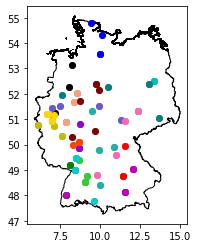

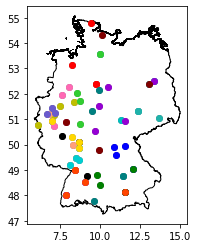

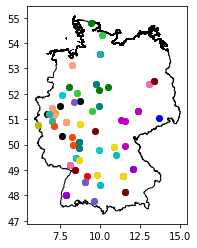

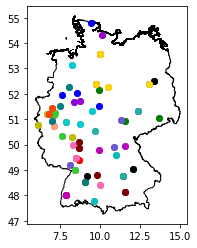

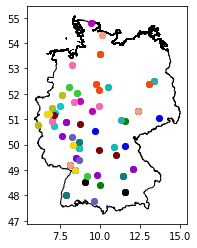

In [135]:



def sort_gameday(gameday: list, df: pd.DataFrame):
    sorted_gameday = []
    
    min_travel_d = 10000000
    for team in gameday:
        dist_sum = sum([geopy.distance.geodesic((df.loc[df['Team'] == team, "Längengrad"].values[0],
                                              df.loc[df['Team'] == team, "Breitengrad"].values[0]),
                                             (df.loc[df['Team'] == team2, "Längengrad"].values[0],
                                              df.loc[df['Team'] == team2, "Breitengrad"].values[0])).km 
             for team2 in gameday])
        if dist_sum < min_travel_d and team.strip() != "München Parktruppe":
            host = team
            min_travel_d = dist_sum
            
    sorted_gameday = [host] + [x for x in gameday if x != host]
        
    
    return sorted_gameday


def output_schedule(schedule, df, output_name):
    sched_sorted = []
    for gamedays in schedule:
        gamedays_sorted = []
        for gameday in gamedays:
            gamedays_sorted.append(sort_gameday(gameday, df))
            print(" - ".join(gameday))
        sched_sorted.append(gamedays_sorted)
        print()
        print(" - - - - - - -")
        print() 
    
    schedule2 =  [item for sublist in sched_sorted for item in sublist]  
    df_new = pd.DataFrame(schedule2, columns=["Host","Team_2","Team_3","Team_4","Team_5"])
    df_new.to_excel("{}.xlsx".format(output_name))


    gdf = gpd.read_file("DEU_adm.zip")
    a=0
    plt.clf()

    clrs = [
    'b',  # Blue
    'g',  # Green
    'r',  # Red
    'c',  # Cyan
    'm',  # Magenta
    'y',  # Yellow
    'k',  # Black
    '#FFA07A',  # LightSalmon
    '#20B2AA',  # LightSeaGreen
    '#9400D3',  # DarkViolet
    '#32CD32',  # LimeGreen
    '#FF4500',  # OrangeRed
    '#6A5ACD',  # SlateBlue
    '#00CED1',  # DarkTurquoise
    '#FF69B4',  # HotPink
    '#800000',  # Maroon
    '#008080',  # Teal
    '#FFD700',  # Gold
    '#8B4513',  # SaddleBrown
    '#2E8B57',  # SeaGreen
]
    for gamedays in schedule:
        gdf.plot(color='white', edgecolor='black' )
        plt.scatter(df["Längengrad"],df["Breitengrad"], color="grey")
        
        for idx,gameday in enumerate(gamedays):
            assert len(gameday) in [4,5]
            df_small = df[df["Team"].isin(gameday)]
            plt.scatter(df_small["Längengrad"],df_small["Breitengrad"], color=clrs[idx])
        
        #plt.show()
        plt.savefig("plots/{}.png".format(gamedays[-1][-1]))
        a+=1

output_schedule(best_sched, df, "regio_schedule")    

In [87]:
a = [1,2,3,4,5]
random.shuffle(a)
a

[3, 2, 1, 5, 4]